In [2]:
# Import necessary libraries
import random
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch

# Check if CUDA (GPU) is available for PyTorch, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
# Define directory paths for datasets
DATASET_PATH = "/kaggle/input/ucf101-action-recognition/"

TRAIN_DIR = DATASET_PATH + 'train'
VAL_DIR = DATASET_PATH + 'val'
TEST_DIR = DATASET_PATH + 'test'

# Define paths for CSV metadata files (train, validation, and test data)
TRAIN_CSV = DATASET_PATH + 'train.csv'
VAL_CSV = DATASET_PATH + 'val.csv'
TEST_CSV = DATASET_PATH + 'test.csv'


In [5]:
# Load the CSV files into pandas DataFrames
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)


In [6]:
# Define a list of labels to focus on (for specific actions)
PENTA_LABELS = ['BenchPress', 'BoxingPunchingBag', 'HorseRiding', 'PlayingCello', 'PlayingGuitar']


In [7]:
# Filter the DataFrames to include only rows corresponding to the selected labels
train_penta_df = train_df[train_df['label'].isin(PENTA_LABELS)]
val_penta_df = val_df[val_df['label'].isin(PENTA_LABELS)]
test_penta_df = test_df[test_df['label'].isin(PENTA_LABELS)]


In [8]:
# Shuffle the dataframes and reset the indices to ensure randomness
train_penta_df = train_penta_df.sample(frac=1.0).reset_index(drop=True)
val_penta_df = val_penta_df.sample(frac=1.0).reset_index(drop=True)
test_penta_df = test_penta_df.sample(frac=1.0).reset_index(drop=True)


In [9]:
# Add full paths to video clips in the 'clip_path' column
train_penta_df['clip_path'] = train_penta_df['clip_path'].apply(lambda path: DATASET_PATH[:-1] + path)
val_penta_df['clip_path'] = val_penta_df['clip_path'].apply(lambda path: DATASET_PATH[:-1] + path)
test_penta_df['clip_path'] = test_penta_df['clip_path'].apply(lambda path: DATASET_PATH[:-1] + path)


In [10]:
# View first 10 samples from the binary train set
train_penta_df.head(10)

,clip_name,clip_path,label
0,v_PlayingGuitar_g09_c03,/kaggle/input/ucf101-action-recognition/train/...,PlayingGuitar
1,v_BenchPress_g18_c02,/kaggle/input/ucf101-action-recognition/train/...,BenchPress
2,v_PlayingCello_g13_c06,/kaggle/input/ucf101-action-recognition/train/...,PlayingCello
3,v_BenchPress_g06_c02,/kaggle/input/ucf101-action-recognition/train/...,BenchPress
4,v_PlayingCello_g23_c04,/kaggle/input/ucf101-action-recognition/train/...,PlayingCello
5,v_BoxingPunchingBag_g01_c04,/kaggle/input/ucf101-action-recognition/train/...,BoxingPunchingBag
6,v_BoxingPunchingBag_g05_c05,/kaggle/input/ucf101-action-recognition/train/...,BoxingPunchingBag
7,v_BoxingPunchingBag_g20_c05,/kaggle/input/ucf101-action-recognition/train/...,BoxingPunchingBag
8,v_HorseRiding_g03_c07,/kaggle/input/ucf101-action-recognition/train/...,HorseRiding
9,v_BenchPress_g01_c04,/kaggle/input/ucf101-action-recognition/train/...,BenchPress


In [11]:
# Define a function to load video frames from a video file
def load_video_frames(video_path, frame_step=1, frame_count=10):
    """
    Load frames from a video with a specified frame step and number of frames.
    If the video doesn't have enough frames, generate black frames to fill the remainder.
    
    Args:
        video_path (str): Path to the video file.
        frame_step (int): Step to skip frames. Defaults to 1 (no skipping).
        frame_count (int): Number of frames to load. Defaults to 10.
    
    Returns:
        list: List of video frames (in RGB format).
    """
    cap = cv2.VideoCapture(video_path)  # Open the video file
    frames = []
    frame_idx = 0

    while cap.isOpened() and len(frames) < frame_count:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_step == 0:
            # Convert from BGR (OpenCV format) to RGB (Matplotlib format)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        frame_idx += 1

    cap.release()  # Close the video capture object

    # Get the shape of the first frame (width, height, channels)
    img_shape = frames[0].shape

    # Generate black frames if the video has fewer frames than required
    while len(frames) < frame_count:
        black_frame = np.zeros(img_shape, dtype=np.uint8)  # Create black frames
        frames.append(black_frame)

    return frames

In [12]:
# Define a function to display frames from the video in a grid layout
def view_frames(frames, frame_step=1):
    """
    Display frames in a grid layout with frame number and frame step in the title.
    
    Args:
        frames (list): List of frames to display.
        frame_step (int): Frame step used for loading the frames.
    """
    n = len(frames)  # Total number of frames
    rows = n // 5  # Calculate number of rows for the grid
    if n % 5 > 0:
        rows += 1

    plt.figure(figsize=(18, 8))  # Set the figure size for the grid
    for idx, frame in enumerate(frames):
        plt.subplot(rows, 5, idx + 1)  # Create a subplot for each frame
        plt.title(f"Frame #{idx * frame_step + 1}")  # Title with frame number
        plt.axis("off")  # Hide axes
        plt.imshow(frame)  # Display the frame
    plt.show()

In [13]:
# Select a random sample from the training set and print the video path
sample_path = random.sample(train_penta_df['clip_path'].to_list(), 1)[0]
print(f"Sample path: {sample_path}")

# Load frames from the selected video sample
frame_step = 15
sample_video = load_video_frames(sample_path, frame_step=frame_step, frame_count=10)


Sample path: /kaggle/input/ucf101-action-recognition/train/HorseRiding/v_HorseRiding_g08_c06.avi


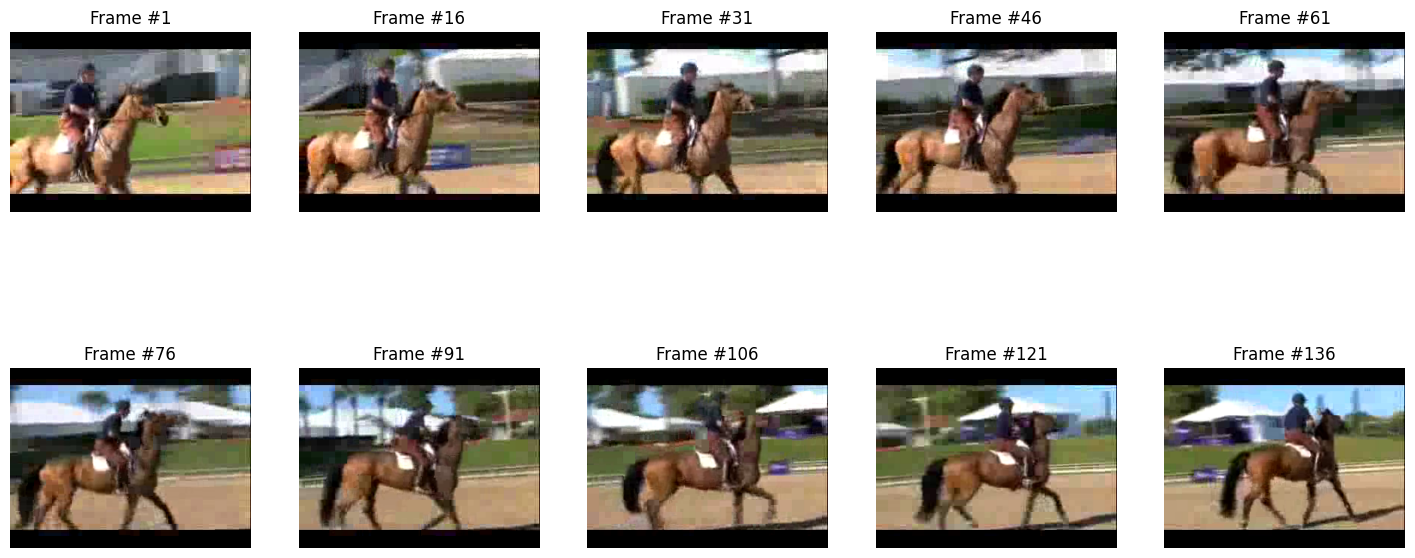

In [14]:
# Display the video frames
view_frames(sample_video, frame_step=frame_step)


In [15]:
# Import necessary classes for Dataset and DataLoader from PyTorch
from torch.utils.data import Dataset, DataLoader


In [16]:
# Define a custom dataset class to handle video sequences
class VideoDataset(Dataset):
    def __init__(self, dataframe, input_frames=10, output_frames=5, stride=3, frame_size=(64, 64), transform=None, color_mode='grayscale'):
        """
        Initialize the dataset with the specified parameters.
        
        Args:
            dataframe (pd.DataFrame): DataFrame containing video file paths.
            input_frames (int): Number of input frames for the model.
            output_frames (int): Number of frames to predict.
            stride (int): Step size to skip between sequences.
            frame_size (tuple): Tuple specifying frame width and height.
            transform (callable, optional): Transform to apply on each frame.
            color_mode (str): 'grayscale' or 'rgb'.
        """
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.sequence_length = self.input_frames + self.output_frames
        self.stride = stride
        self.transform = transform
        self.color_mode = color_mode
        self.frame_size = frame_size
        self.sequences = []  # List to store the sequences of frames
        self.cached_video = None  # Cache the video frames
        self.cached_video_path = None  # Path of the cached video

        # Iterate through the DataFrame to build the sequences list
        for idx, row in dataframe.iterrows():
            video_path = row['clip_path']
            total_frames = self.get_total_frames(video_path)

            # Check if the video has enough frames for the sequence
            if total_frames < self.sequence_length:
                total_sequences = 1  # Only one sequence if the video is too short
            else:
                total_sequences = (total_frames - self.sequence_length) // self.stride + 1

            # Create sequences with the specified stride
            for seq_idx in range(total_sequences):
                start_idx = seq_idx * self.stride
                self.sequences.append({
                    'video_path': video_path,
                    'start_idx': start_idx,
                    'total_frames': total_frames
                })

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        """Fetch a sequence of frames for training or testing."""
        sequence_info = self.sequences[idx]
        video_path = sequence_info['video_path']
        start_idx = sequence_info['start_idx']
        total_frames = sequence_info['total_frames']

        # Check if the video is cached, if not, load the video
        if self.cached_video_path != video_path:
            self.cached_video = self.load_video(video_path)
            self.cached_video_path = video_path

        # Extract the frames from the cached video
        end_idx = start_idx + self.sequence_length
        frames = self.cached_video[start_idx:end_idx]

        # If the frames are fewer than required, augment them with the last frame
        if len(frames) < self.sequence_length:
            frames = self.augment_frames(frames, self.sequence_length)

        # Split into input and target sequences
        input_seq = frames[:self.input_frames]
        target_seq = frames[self.input_frames:]

        # Convert to grayscale if necessary
        if self.color_mode == 'grayscale':
            input_seq = input_seq[..., np.newaxis]
            target_seq = target_seq[..., np.newaxis]

        # Change frame dimensions to match PyTorch input format (C, H, W)
        input_seq = input_seq.transpose(0, 3, 1, 2)
        target_seq = target_seq.transpose(0, 3, 1, 2)

        # Convert to torch tensors and normalize the pixel values
        input_seq = torch.from_numpy(input_seq).float() / 255.0
        target_seq = torch.from_numpy(target_seq).float() / 255.0

        # Apply any additional transformations (e.g., data augmentation)
        if self.transform:
            input_seq = self.apply_transform(input_seq)
            target_seq = self.apply_transform(target_seq)

        return {'input': input_seq, 'target': target_seq}

    def load_video(self, video_path):
        """Load all frames from a video into memory."""
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, self.frame_size)
            if self.color_mode == 'grayscale':
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return np.array(frames)

    def augment_frames(self, frames, required_length):
        """Augment frames to meet the required length by repeating the last frame."""
        current_length = len(frames)
        deficit = required_length - current_length

        # Repeat the last frame to fill the gap
        last_frame = frames[-1] if len(frames) > 0 else np.zeros((self.frame_size[1], self.frame_size[0], 3), dtype=np.uint8)
        augmented_frames = np.concatenate([frames, np.repeat(last_frame[np.newaxis, ...], deficit, axis=0)], axis=0)

        return augmented_frames

    def get_total_frames(self, video_path):
        """Get the total number of frames in a video."""
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return total_frames

    def apply_transform(self, sequence):
        """Apply the transform to each frame in the sequence."""
        transformed_sequence = []
        for frame in sequence:
            frame = self.transform(frame)
            transformed_sequence.append(frame)
        if len(transformed_sequence) == 0:
            raise ValueError("Transformed sequence is empty.")
        transformed_sequence = torch.stack(transformed_sequence)
        return transformed_sequence

In [17]:
# Parameters for dataset and dataloaders
batch_size = 32                 # Number of sequences per batch
color_mode = 'rgb'              # or 'grayscale'
input_frames = 10               # Number of input frames for prediction
output_frames = 5               # Number of frames to predict
stride = 5                      # Number of frames to skip between sequences (stride - 1)
frame_size = (64, 64)           # Resize each frame to 64x64
num_workers = 0                 # Number of workers for data loading

In [18]:
# Define the normalization transform for input frames
import torchvision.transforms as transforms

if color_mode == 'grayscale':
    transform = transforms.Compose([transforms.Normalize(mean=[0.5], std=[0.5])])
else:
    transform = transforms.Compose([transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])


In [19]:
# Create the dataset instances for training, validation, and test
train_dataset = VideoDataset(train_penta_df, input_frames, output_frames, stride, frame_size, transform, color_mode)
val_dataset = VideoDataset(val_penta_df, input_frames, output_frames, stride, frame_size, transform, color_mode)
test_dataset = VideoDataset(test_penta_df, input_frames, output_frames, stride, frame_size, transform, color_mode)


In [20]:
# Create data loaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [21]:
# Print the total number of batches in the train loader
print(f"Total train batches: {len(train_loader)}")

# Print the total number of sequences in the training dataset
print(f"Total train sequences: {len(train_dataset)}")

# Print the total number of frames in the training dataset
print(f"Total train frames: {len(train_dataset) * train_dataset.sequence_length}")


Total train batches: 703
Total train sequences: 22486
Total train frames: 337290


In [22]:
# Import necessary libraries
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from tqdm import tqdm
import torchvision.models as models
import torchvision.models.vgg as VGG16_Weights
from torchmetrics.image import StructuralSimilarityIndexMeasure

In [23]:
class SpatioTemporalLSTMCell(nn.Module):
    def __init__(self, in_channels, hidden_channels, height, width, filter_size=5, stride=1):
        """
        This class defines a Spatio-Temporal LSTM Cell that processes both spatial and temporal features.
        It incorporates 2D convolutions for spatial processing and uses LSTM gates for temporal information.

        Args:
            in_channels (int): Number of input channels (e.g., RGB channels of input image).
            hidden_channels (int): Number of channels in the hidden state of the LSTM.
            height (int): Height of the input image.
            width (int): Width of the input image.
            filter_size (int): Size of the convolution filter. Default is 5.
            stride (int): The stride for the convolution. Default is 1.
        """
        super(SpatioTemporalLSTMCell, self).__init__()

        self.hidden_channels = hidden_channels
        padding = filter_size // 2
        self._forget_bias = 1.0
        self.height = height
        self.width = width

        # Convolution layers for input, hidden state, memory, and output.
        self.conv_x = nn.Conv2d(in_channels, hidden_channels * 7, kernel_size=filter_size, stride=stride, padding=padding, bias=False)
        self.conv_h = nn.Conv2d(hidden_channels, hidden_channels * 4, kernel_size=filter_size, stride=stride, padding=padding, bias=False)
        self.conv_m = nn.Conv2d(hidden_channels, hidden_channels * 3, kernel_size=filter_size, stride=stride, padding=padding, bias=False)
        self.conv_o = nn.Conv2d(hidden_channels * 2, hidden_channels, kernel_size=filter_size, stride=stride, padding=padding, bias=False)

        # Last convolution layer to produce final output.
        self.conv_last = nn.Conv2d(hidden_channels * 2, hidden_channels, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x_t, h_t, c_t, m_t):
        """
        Forward pass for the SpatioTemporalLSTMCell.

        Args:
            x_t (Tensor): The input frame at time step t (batch_size, channels, height, width).
            h_t (Tensor): The hidden state from the previous time step (batch_size, hidden_channels, height, width).
            c_t (Tensor): The cell state from the previous time step (batch_size, hidden_channels, height, width).
            m_t (Tensor): The memory state (batch_size, hidden_channels, height, width).

        Returns:
            h_new (Tensor): Updated hidden state.
            c_new (Tensor): Updated cell state.
            m_new (Tensor): Updated memory state.
        """
        # Apply convolutions to the input and the previous hidden state
        x_concat = self.conv_x(x_t)
        h_concat = self.conv_h(h_t)
        m_concat = self.conv_m(m_t)

        # Split the convolution outputs into individual gates for LSTM operations
        i_x, f_x, g_x, i_xp, f_xp, g_xp, o_x = torch.split(x_concat, self.hidden_channels, dim=1)
        i_h, f_h, g_h, o_h = torch.split(h_concat, self.hidden_channels, dim=1)
        i_m, f_m, g_m = torch.split(m_concat, self.hidden_channels, dim=1)

        # LSTM gates (input, forget, and output) for cell state and memory update
        i_t = torch.sigmoid(i_x + i_h)
        f_t = torch.sigmoid(f_x + f_h + self._forget_bias)
        g_t = torch.tanh(g_x + g_h)
        c_new = f_t * c_t + i_t * g_t  # Update cell state

        # Memory gates for the memory update
        i_tp = torch.sigmoid(i_xp + i_m)
        f_tp = torch.sigmoid(f_xp + f_m + self._forget_bias)
        g_tp = torch.tanh(g_xp + g_m)
        m_new = f_tp * m_t + i_tp * g_tp  # Update memory state

        # Concatenate the updated cell and memory states, and compute the output
        mem = torch.cat((c_new, m_new), 1)
        o_t = torch.sigmoid(o_x + o_h + self.conv_o(mem))
        h_new = o_t * torch.tanh(self.conv_last(mem))

        return h_new, c_new, m_new


In [24]:
class PredRNN(nn.Module):
    def __init__(self, config):
        """
        The PredRNN model predicts future frames in a sequence using stacked SpatioTemporal LSTM cells.

        Args:
            config (Config): Configuration object that defines model parameters such as layers, hidden channels, etc.
        """
        super(PredRNN, self).__init__()

        self.config = config
        self.frame_channels = config.img_channels
        self.num_layers = config.num_layers
        self.num_hidden = config.num_hidden
        self.output_frames = config.output_frames

        # Initialize the list of LSTM cells for each layer
        cell_list = []
        for i in range(self.num_layers):
            in_channels = self.frame_channels if i == 0 else self.num_hidden[i - 1]
            cell = SpatioTemporalLSTMCell(
                in_channels=in_channels,
                hidden_channels=self.num_hidden[i],
                height=config.img_height,
                width=config.img_width,
                filter_size=config.filter_size,
                stride=config.stride,
            )
            cell_list.append(cell)

        self.cell_list = nn.ModuleList(cell_list)

        # Final convolution to output the generated frames
        self.conv_last = nn.Conv2d(
            self.num_hidden[-1],
            self.frame_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )

    def forward(self, input_frames):
        """
        Forward pass for the PredRNN model.

        Args:
            input_frames (Tensor): The input sequence of frames (batch_size, input_length, channels, height, width).

        Returns:
            gen_frames (Tensor): The predicted frames for future time steps.
        """
        batch_size, seq_length, _, height, width = input_frames.size()

        # Initialize hidden states, cell states, and memory state
        h_t = []
        c_t = []
        m_t = torch.zeros(batch_size, self.num_hidden[0], height, width).to(self.config.device)

        for i in range(self.num_layers):
            h_t.append(torch.zeros(batch_size, self.num_hidden[i], height, width).to(self.config.device))
            c_t.append(torch.zeros(batch_size, self.num_hidden[i], height, width).to(self.config.device))

        # To store the generated frames
        gen_frames = []

        # Process the input sequence frame by frame
        for t in range(seq_length - 1):  # Only use input sequence length for the first part
            x = input_frames[:, t]  # Get the t-th frame from the input sequence
            h_t[0], c_t[0], m_t = self.cell_list[0](x, h_t[0], c_t[0], m_t)  # Compute next hidden states

            # Propagate the hidden state through the layers
            for i in range(1, self.num_layers):
                h_t[i], c_t[i], m_t = self.cell_list[i](h_t[i - 1], h_t[i], c_t[i], m_t)

            # The predicted frame at time step t
            x_gen = self.conv_last(h_t[-1])
            gen_frames.append(x_gen.unsqueeze(1))

        # Concatenate all the generated frames (10 frames) and select the last 5 frames as output
        gen_frames = torch.cat(gen_frames, dim=1)  # Output shape: [batch_size, 10, channels, height, width]
        return gen_frames[:, -self.output_frames:, :, :, :]  # Select frames 6-10 as predicted output


In [25]:
class Config:
    def __init__(self):
        """
        Configuration for the PredRNN model.
        Defines hyperparameters such as image size, number of layers, number of hidden channels, etc.
        """
        self.img_height = 64                # Image height
        self.img_width = 64                 # Image width
        self.img_channels = 3               # RGB channels
        self.input_length = 10              # Input frames for prediction
        self.output_frames = 5              # Output frames to predict
        self.total_length = 15              # Input + predicted frames
        self.num_layers = 3                 # Number of layers in the model
        self.num_hidden = [64, 64, 64]      # Hidden channels for each layer
        self.filter_size = 3                # Filter Size for convolutional layers
        self.stride = 1                     # Stride for convolutional layers
        self.device = device                # Device (CPU or GPU)


In [26]:
# Model Initialization
config = Config()
model = PredRNN(config).to(config.device)  # Move model to selected device (GPU or CPU)

# Print model architecture
print(f"Model Architecture:\n{model}\n")

Model Architecture:
PredRNN(
  (cell_list): ModuleList(
    (0): SpatioTemporalLSTMCell(
      (conv_x): Conv2d(3, 448, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_h): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_m): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_o): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_last): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1-2): 2 x SpatioTemporalLSTMCell(
      (conv_x): Conv2d(64, 448, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_h): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_m): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_o): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_last): Conv2d

In [27]:
# Create a dummy input tensor for testing the model's forward pass
dummy_input = torch.randn(1, 10, 3, 64, 64).to(config.device)  # Shape: [batch_size, input_length, channels, height, width]

# Print model summary to understand parameter counts and shapes
summary(model, input_data=dummy_input, verbose=1)


Layer (type:depth-idx)                   Output Shape              Param #
PredRNN                                  [1, 5, 3, 64, 64]         --
├─ModuleList: 1-17                       --                        (recursive)
│    └─SpatioTemporalLSTMCell: 2-1       [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 448, 64, 64]          12,096
│    │    └─Conv2d: 3-2                  [1, 256, 64, 64]          147,456
│    │    └─Conv2d: 3-3                  [1, 192, 64, 64]          110,592
│    │    └─Conv2d: 3-4                  [1, 64, 64, 64]           73,728
│    │    └─Conv2d: 3-5                  [1, 64, 64, 64]           8,192
│    └─SpatioTemporalLSTMCell: 2-2       [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-6                  [1, 448, 64, 64]          258,048
│    │    └─Conv2d: 3-7                  [1, 256, 64, 64]          147,456
│    │    └─Conv2d: 3-8                  [1, 192, 64, 64]          110,592
│    │    └─Conv2d: 3-9                 

Layer (type:depth-idx)                   Output Shape              Param #
PredRNN                                  [1, 5, 3, 64, 64]         --
├─ModuleList: 1-17                       --                        (recursive)
│    └─SpatioTemporalLSTMCell: 2-1       [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 448, 64, 64]          12,096
│    │    └─Conv2d: 3-2                  [1, 256, 64, 64]          147,456
│    │    └─Conv2d: 3-3                  [1, 192, 64, 64]          110,592
│    │    └─Conv2d: 3-4                  [1, 64, 64, 64]           73,728
│    │    └─Conv2d: 3-5                  [1, 64, 64, 64]           8,192
│    └─SpatioTemporalLSTMCell: 2-2       [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-6                  [1, 448, 64, 64]          258,048
│    │    └─Conv2d: 3-7                  [1, 256, 64, 64]          147,456
│    │    └─Conv2d: 3-8                  [1, 192, 64, 64]          110,592
│    │    └─Conv2d: 3-9                 

In [28]:
output = model(dummy_input)
print(output.shape)               # Should print: torch.Size([1, 5, 3, 64, 64])

torch.Size([1, 5, 3, 64, 64])


In [29]:
class EarlyStopping:
    def __init__(self, patience=2, verbose=False, delta=0):
        """
        Early stopping implementation for training. Stops training if validation loss doesn't improve for a specified number of epochs.

        Args:
            patience (int): Number of epochs to wait after the last improvement in validation loss. Default is 2.
            verbose (bool): If True, prints a message every time validation loss improves. Default is False.
            delta (float): Minimum change in validation loss to consider it an improvement. Default is 0.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        """
        Checks if early stopping condition is met. If validation loss hasn't improved, it stops the training.
        
        Args:
            val_loss (float): Current validation loss.
            model (nn.Module): The model being trained.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves the model when validation loss decreases."""
        if self.verbose:
            print(f'Validation loss decreased. Saving model...')
            model_path = f'checkpoint_{val_loss:.6f}.pth'  # Save model with validation loss in the filename
            torch.save(model.state_dict(), model_path)


In [31]:
# Define loss function
criterion = nn.MSELoss()  # Mean Squared Error Loss for frame prediction tasks

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=2e-4)  # Adam optimizer
early_stopping = EarlyStopping(patience=3, verbose=True)  # Early stopping object
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5, threshold=0.001)

# Initialize SSIM metric for image similarity
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(config.device)

# Load pre-trained VGG16 for perceptual loss calculation
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features.to(config.device).eval()

# Perceptual loss function based on VGG16 features
def perceptual_loss(pred, target):
    """
    Calculates perceptual loss by passing the frames through a pre-trained VGG16 network.
    """
    p_loss = 0.0
    for i in range(pred.size(1)):  # Loop over the sequence length dimension
        pred_frame = pred[:, i, :, :, :]  # Get the predicted frame
        target_frame = target[:, i, :, :, :]  # Get the target frame

        # Extract features using VGG16
        pred_features = vgg16(pred_frame)
        target_features = vgg16(target_frame)

        # Compute MSE loss for the features
        p_loss += nn.MSELoss()(pred_features, target_features)

    # Average over all frames in the sequence
    p_loss /= pred.size(1)
    return p_loss

# Early Stopping Parameters
early_stopping_patience = 2
best_val_loss = float('inf')
patience_counter = 0

# Loss Tracking
train_losses = []
val_losses = []
val_ssim = []


In [32]:
# Training Loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs = batch['input'].to(config.device)  # [batch_size, 10, channels, height, width]
        targets = batch['target'].to(config.device)  # [batch_size, 5, channels, height, width]

        # Pass only the input sequence (first 10 frames) to the model
        input_sequence = inputs  # [batch_size, input_length=10, channels, height, width]

        # Get the predicted frames from the model
        outputs = model(input_sequence)  # Output shape: [batch_size, 5, channels, height, width]

        # Compute MSE loss between predicted frames and ground truth target frames
        loss = criterion(outputs, targets)  # Compare predicted frames (frames 6-10) with target frames

        # Add perceptual loss
        p_loss = perceptual_loss(outputs, targets)
        total_loss = loss + 0.1 * p_loss  # Adjust weight for perceptual loss as needed

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation Loop
    model.eval()
    val_loss = 0.0
    ssim_score = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            inputs = batch['input'].to(config.device)
            targets = batch['target'].to(config.device)

            # Get the predicted frames from the model
            outputs = model(inputs)

            # Compute MSE loss for validation
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

            # Compute SSIM for each frame in the sequence and average
            batch_ssim = 0.0
            for t in range(targets.size(1)):
                target_frame = targets[:, t, :, :, :]  # Shape: [batch_size, channels, H, W]
                output_frame = outputs[:, t, :, :, :]  # Shape: [batch_size, channels, H, W]
                ssim_value = ssim_metric(output_frame, target_frame)
                batch_ssim += ssim_value.item()
            batch_ssim /= targets.size(1)
            ssim_score += batch_ssim * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        ssim_score /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_ssim.append(ssim_score)

    # Print Learning Rate
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation SSIM: {ssim_score:.4f}, Learning Rate: {lr:.6e}")

    # Check for early stopping
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    # Step the scheduler
    scheduler.step(val_loss)

Validation Epoch 1/20: 100%|██████████| 115/115 [01:09<00:00,  1.65it/s]


Epoch [1/20], Training Loss: 0.0902, Validation Loss: 0.0491, Validation SSIM: 0.6664, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 2/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [2/20], Training Loss: 0.0675, Validation Loss: 0.0478, Validation SSIM: 0.6715, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 3/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [3/20], Training Loss: 0.0658, Validation Loss: 0.0467, Validation SSIM: 0.6744, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 4/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [4/20], Training Loss: 0.0647, Validation Loss: 0.0456, Validation SSIM: 0.6762, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 5/20: 100%|██████████| 115/115 [01:04<00:00,  1.80it/s]


Epoch [5/20], Training Loss: 0.0636, Validation Loss: 0.0440, Validation SSIM: 0.6773, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 6/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [6/20], Training Loss: 0.0625, Validation Loss: 0.0429, Validation SSIM: 0.6801, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 7/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [7/20], Training Loss: 0.0615, Validation Loss: 0.0423, Validation SSIM: 0.6811, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 8/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [8/20], Training Loss: 0.0609, Validation Loss: 0.0419, Validation SSIM: 0.6823, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 9/20: 100%|██████████| 115/115 [01:04<00:00,  1.79it/s]


Epoch [9/20], Training Loss: 0.0603, Validation Loss: 0.0415, Validation SSIM: 0.6828, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 10/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [10/20], Training Loss: 0.0598, Validation Loss: 0.0412, Validation SSIM: 0.6839, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 11/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [11/20], Training Loss: 0.0594, Validation Loss: 0.0408, Validation SSIM: 0.6847, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 12/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [12/20], Training Loss: 0.0589, Validation Loss: 0.0405, Validation SSIM: 0.6852, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 13/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [13/20], Training Loss: 0.0585, Validation Loss: 0.0403, Validation SSIM: 0.6852, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 14/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [14/20], Training Loss: 0.0581, Validation Loss: 0.0400, Validation SSIM: 0.6860, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 15/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [15/20], Training Loss: 0.0577, Validation Loss: 0.0398, Validation SSIM: 0.6866, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 16/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [16/20], Training Loss: 0.0573, Validation Loss: 0.0396, Validation SSIM: 0.6862, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 17/20: 100%|██████████| 115/115 [01:04<00:00,  1.79it/s]


Epoch [17/20], Training Loss: 0.0569, Validation Loss: 0.0394, Validation SSIM: 0.6857, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 18/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]


Epoch [18/20], Training Loss: 0.0566, Validation Loss: 0.0392, Validation SSIM: 0.6856, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 19/20: 100%|██████████| 115/115 [01:03<00:00,  1.81it/s]


Epoch [19/20], Training Loss: 0.0562, Validation Loss: 0.0392, Validation SSIM: 0.6847, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


Validation Epoch 20/20: 100%|██████████| 115/115 [01:03<00:00,  1.80it/s]

Epoch [20/20], Training Loss: 0.0560, Validation Loss: 0.0389, Validation SSIM: 0.6863, Learning Rate: 2.000000e-04
Validation loss decreased. Saving model...


In [33]:
# Save the model checkpoint
torch.save(model.state_dict(), 'predrnn_model.pth')


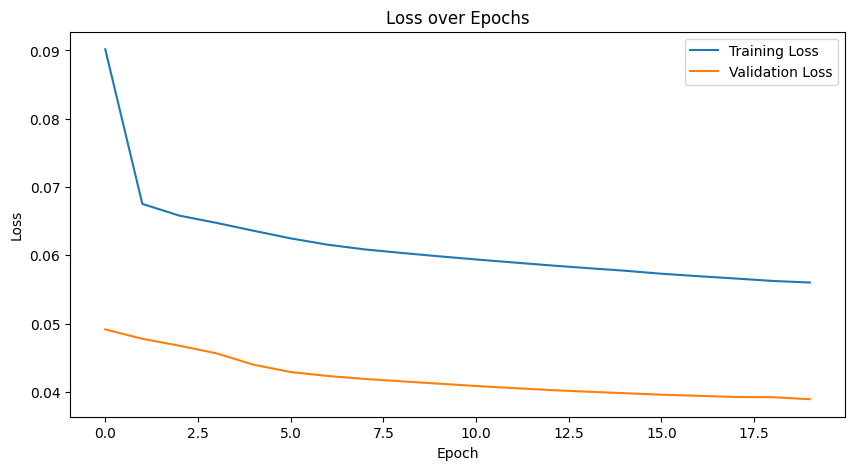

In [37]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

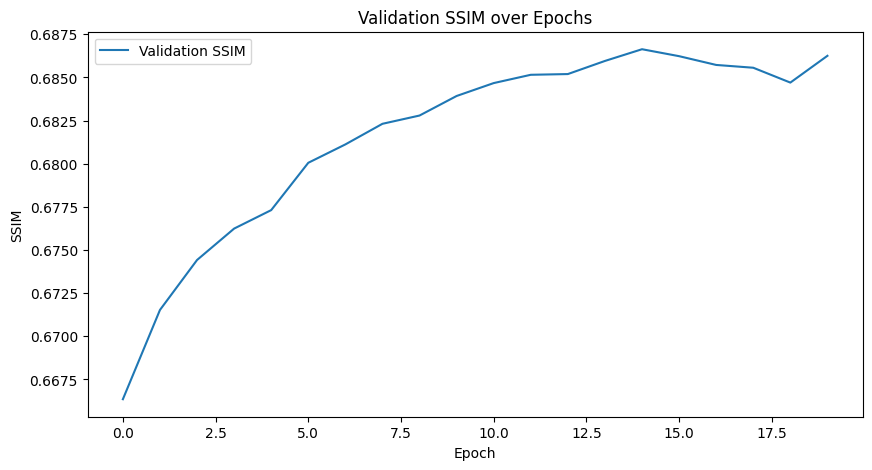

In [38]:
# Plotting Validation SSIM
plt.figure(figsize=(10,5))
plt.plot(val_ssim, label='Validation SSIM')
plt.title('Validation SSIM over Epochs')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()
plt.show()


In [39]:
# Evaluation on Test Set
model.eval()
test_loss = 0.0
test_ssim = 0.0
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

        # Compute SSIM
        batch_ssim = 0.0
        for t in range(targets.size(1)):
            target_frame = targets[:, t, :, :, :]
            output_frame = outputs[:, t, :, :, :]
            ssim_value = ssim_metric(output_frame, target_frame)
            batch_ssim += ssim_value.item()
        batch_ssim /= targets.size(1)
        test_ssim += batch_ssim * inputs.size(0)

test_loss /= len(test_loader.dataset)
test_ssim /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, Test SSIM: {test_ssim:.4f}')


Test Loss: 0.0352, Test SSIM: 0.6967
